## Load model's weight, and produce heatmaps

**Used Hyperparameter**<br>
Level: 2,3 images <br>
Number of train,val,test: 9, 3, 3 <br>
train's stride : 200 <br>
test's stride: 299 <br>
tissue percent min: 50 <br>


----------------------------------------------<br>
train_index = [2,4,5,6,7,15,17,19,20]<br>
valid_index = [0,12,18]<br>
test_index = [11,13,16]<br>

In [9]:
import os

# Initialization
lowest_level = 2
highest_level = 3
train_val_stride = 200
test_stride = 299
tissue_p_min = 50

dir = '/content/drive/MyDrive/Applied_Deep_Learning_Project/'
current_dir = 'Lev_345_split_933_stride_150_pmin_50'
saving_dir = os.path.join(dir,current_dir)
display(saving_dir)


'/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_345_split_933_stride_150_pmin_50'

In [3]:
# Mount drive
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)
print()

# Check TensorFlow version
import tensorflow as tf 
print("TF version: ", tf.__version__)
print()

# Check which GPU with available RAM
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

Mounted at /content/drive

TF version:  2.4.0

Found GPU at: /device:GPU:0
name, driver_version, memory.total [MiB]
Tesla V100-SXM2-16GB, 418.67, 16130 MiB


In [4]:
!apt-get install openslide-tools  # Openslide , Install the OpenSlide C library and Python bindings
!apt-get install python3-openslide # After installing these libraries, use `Runtime -> restart and run all` on the menu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (1,156 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpac

In [5]:
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_curve, auc
import os
from PIL import Image
import itertools
import pathlib
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from itertools import chain
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from matplotlib.patches import Rectangle
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Gets difference of two lists using set operator
def difference(L1, L2):
    return (list(list(set(L1)-set(L2)) + list(set(L2)-set(L1))))

# detect and remove if number of images and masks are different
def balance_imgs(image_path_l, mask_path_l):
  img_num_l = [re.findall(r'\d+', string)[0] for string in image_path_l ] # list of image numbers
  mask_num_l = [re.findall(r'\d+', string)[0] for string in mask_path_l ] # list of mask's image numbers

  img_len = len(img_num_l)
  mask_len = len(mask_num_l)

  # delete images that are not same in number of lengths automatically
  if img_len != mask_len:
    print("Tissue image length: {}".format(len(image_path_l)))
    print("Mask image length: {}".format(len(mask_path_l)))

    diff_img_num = difference(img_num_l,mask_num_l)[0]

    if img_len > mask_len: # i.e. need to find extra image and delete
      print("Removed image number {} since there is no corresponding biopsy image".format(diff_img_num))
      del image_path_l[img_num_l.index(diff_img_num)]

    else: 
      print("Removed mask number {} since there is no corresponding  image".format(diff_img_num))
      del mask_path_l[mask_num_l.index(diff_img_num)]

  return image_path_l, mask_path_l


# Note: since importing slides from Professor's Google API does not work sometimes,
# we downloaded the images to 'locally' in Google Drive
directory = '/content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/'

biopsy_path_list = []
mask_path_list = []

for file in os.scandir(directory):
  
  if ("tif" in file.name):
    if ("mask" in file.name):
      mask_path_list.append(file.path) 
  
    else:
      biopsy_path_list.append(file.path)

# # Automatically removes images that are not both exists in image and masks
biopsy_path_list,mask_path_list = balance_imgs(biopsy_path_list,mask_path_list)

biopsy_path_list.sort()
mask_path_list.sort()

Tissue image length: 22
Mask image length: 21
Removed image number 038 since there is no corresponding biopsy image


In [7]:
def get_open_slide(tissue_path, mask_path, return_tissue):
# Function that opens an image based on path
# Note: return_tissue = boolean value, 
#      Ture -> reads tissue img, False -> reads masks image

  slide = open_slide(tissue_path)
  print ("Read WSI from %s with width: %d, height: %d" % (tissue_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))
  mask = open_slide(mask_path)
  print ("Read tumor mask from %s" % (mask_path))

  print("Slide includes %d levels", min(len(slide.level_dimensions),len(mask.level_dimensions)))
  for i in range(min(len(slide.level_dimensions),len(mask.level_dimensions))):
      print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                              slide.level_dimensions[i], 
                                                              slide.level_downsamples[i]))

      assert mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
      assert mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

  if (return_tissue):
    return slide
  else:
    return mask

## Modify This - Loads model weights

In [10]:
filesname_mdl_9_3_wo_ft_wo_da = 'mdl_9_3_wo_ft_wo_da.h5/'
filesname_mdl_9_3_wo_ft_w_da = 'mdl_9_3_wo_ft_w_da.h5/'
filesname_mdl_9_3_w_ft_wo_da = 'mdl_9_3_w_ft_wo_da.h5/'
filesname_mdl_9_3_w_ft_w_da = 'mdl_9_3_w_ft_w_da.h5/'
filesname_mdl_9_3_w_ft_w_da_Dropout = 'mdl_9_3_w_ft_w_da_Dropout.h5/'

path_mdl_9_3_wo_ft_wo_da = os.path.join(saving_dir,'mdl_9_3_wo_ft_wo_da.h5/')
path_mdl_9_3_wo_ft_w_da = os.path.join(saving_dir,'mdl_9_3_wo_ft_w_da.h5/')
path_mdl_9_3_w_ft_wo_da = os.path.join(saving_dir,'mdl_9_3_w_ft_wo_da.h5/')
path_mdl_9_3_w_ft_w_da = os.path.join(saving_dir,'mdl_9_3_w_ft_w_da.h5/')
path_mdl_9_3_w_ft_wo_da_Dropout = os.path.join(saving_dir,'mdl_9_3_w_ft_wo_da_Dropout.h5/')

print(path_mdl_9_3_wo_ft_wo_da) # Version a
print(path_mdl_9_3_wo_ft_w_da) # Version b
print(path_mdl_9_3_w_ft_wo_da) # Version c
print(path_mdl_9_3_w_ft_w_da) # Version d
print(path_mdl_9_3_w_ft_wo_da_Dropout) # Version e

/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_345_split_933_stride_150_pmin_50/mdl_9_3_wo_ft_wo_da.h5/
/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_345_split_933_stride_150_pmin_50/mdl_9_3_wo_ft_w_da.h5/
/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_345_split_933_stride_150_pmin_50/mdl_9_3_w_ft_wo_da.h5/
/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_345_split_933_stride_150_pmin_50/mdl_9_3_w_ft_w_da.h5/
/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_345_split_933_stride_150_pmin_50/mdl_9_3_w_ft_wo_da_Dropout.h5/


In [11]:
# test_index = [11,13,16]
current_test_index = 11

In [12]:
zoom1_test = np.load(os.path.join(saving_dir,'zoom1_test_' + str(current_test_index) + '.npy'))
zoom2_test = np.load(os.path.join(saving_dir,'zoom2_test_' + str(current_test_index) + '.npy'))
zoom3_test = np.load(os.path.join(saving_dir,'zoom3_test_' + str(current_test_index) + '.npy'))
label_test = np.load(os.path.join(saving_dir,'label_test_' + str(current_test_index) + '.npy'))
patches_num_test = np.load(os.path.join(saving_dir,'patches_num_test_' + str(current_test_index) + '.npy'))

In [13]:
test_index = [current_test_index]
biopsy_test = [biopsy_path_list[i] for i in test_index]
mask_test = [mask_path_list[i] for i in test_index]

In [14]:
biopsy_slides_test = [get_open_slide(x,y,True) for x,y in zip(biopsy_test, mask_test)]
mask_slides_test = [get_open_slide(x,y,False) for x,y in zip(biopsy_test, mask_test)]

Read WSI from /content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/tumor_064.tif with width: 97792, height: 220672
Read tumor mask from /content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/tumor_064_mask.tif
Slide includes %d levels 9
Level 0, dimensions: (97792, 220672) downsample factor 1
Level 1, dimensions: (48896, 110336) downsample factor 2
Level 2, dimensions: (24448, 55168) downsample factor 4
Level 3, dimensions: (12224, 27584) downsample factor 8
Level 4, dimensions: (6112, 13792) downsample factor 16
Level 5, dimensions: (3056, 6896) downsample factor 32
Level 6, dimensions: (1528, 3448) downsample factor 64
Level 7, dimensions: (764, 1724) downsample factor 128
Level 8, dimensions: (382, 862) downsample factor 256
Read WSI from /content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/tumor_064.tif with width: 97792, height: 220672
Read tumor mask from /content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/tumor_064_mask.tif
Slid

In [18]:
def create_batch_normalization():
  return tf.keras.layers.BatchNormalization()

In [19]:
def create_inceptionv3(weights='imagenet',include_top = False, input_shape = (299,299,3)):
  base_model = tf.keras.applications.InceptionV3(weights=weights,include_top = include_top, input_shape = input_shape)
  base_model.trainable = False
  return base_model


def create_inceptionv3_fine_tune(weights='imagenet',include_top = False, input_shape = (299,299,3)):
  base_model = tf.keras.applications.InceptionV3(weights=weights,include_top = include_top, input_shape = input_shape)
  
  base_model.trainable = True
  # Let's take a look to see how many layers are in the base model
  print("Number of layers in the base InceptionV3 model: ", len(base_model.layers))
  # Fine-tune from this layer onwards
  fine_tune_at = 100
  print("Start fine tuning at layer: ", fine_tune_at)

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

  return base_model


def create_global_avg_layer():
  return tf.keras.layers.GlobalAveragePooling2D()


def create_dense_layer():
  return tf.keras.layers.Dense(1024, activation='relu')

In [20]:
# Reference used to put multiple inputs
# # https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

def create_model_keras_inputs_three(fine_tune):

  if fine_tune:
    base_model_1 = create_inceptionv3_fine_tune()
    base_model_2 = create_inceptionv3_fine_tune()
    base_model_3 = create_inceptionv3_fine_tune()
  
  else: 
    base_model_1 = create_inceptionv3()
    base_model_2 = create_inceptionv3()
    base_model_3 = create_inceptionv3()

  global_avg_layer = create_global_avg_layer()
  dense_layer = create_dense_layer()

  model_1 = tf.keras.Sequential([
    base_model_1,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  model_2 = tf.keras.Sequential([
    base_model_2,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  model_3 = tf.keras.Sequential([
    base_model_3,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  input1 = Input(shape=(299,299,3))
  input2 = Input(shape=(299,299,3))
  input3 = Input(shape=(299,299,3))
    
  model_concat = concatenate([model_1(input1) ,model_2(input2), model_3(input3)])
  model = Dense(1024, activation='relu')(model_concat)
  model = Dense(1, activation='sigmoid')(model)
  model_final = Model(inputs=[input1,input2,input3],outputs=model)

  return model_final

In [21]:
# Reference used to put multiple inputs
# https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

def create_model_keras_inputs_two_updated(fine_tune):

  if fine_tune:
    base_model_1 = create_inceptionv3_fine_tune()
    base_model_2 = create_inceptionv3_fine_tune()
    base_model_3 = create_inceptionv3_fine_tune()
  
  else: 
    base_model_1 = create_inceptionv3()
    base_model_2 = create_inceptionv3()
    base_model_3 = create_inceptionv3()

  global_avg_layer = create_global_avg_layer()
  dense_layer = create_dense_layer()
  # batch_norm_layer = create_batch_normalization()

  model_1 = tf.keras.Sequential([
    base_model_1,
    global_avg_layer,
    dense_layer,
    # batch_norm_layer
    #prediction_layer
  ])

  model_2 = tf.keras.Sequential([
    base_model_2,
    global_avg_layer,
    dense_layer,
    # batch_norm_layer
    #prediction_layer
  ])

  model_3 = tf.keras.Sequential([
    base_model_3,
    global_avg_layer,
    dense_layer,
    # batch_norm_layer
    #prediction_layer
  ])

  input1 = Input(shape=(299,299,3))
  input2 = Input(shape=(299,299,3))
  input3 = Input(shape=(299,299,3))
    
  model_concat = concatenate([model_1(input1) ,model_2(input2),model_3(input3)], axis =1)
  model = tf.keras.layers.BatchNormalization()(model_concat)
  model = tf.keras.layers.Dropout(0.3)(model)
  model = Dense(1024, activation='relu')(model)
  model = tf.keras.layers.Dropout(0.3)(model)
  model = Dense(128, activation='relu')(model)
  model = tf.keras.layers.Dropout(0.3)(model)
  model = Dense(1, activation='sigmoid')(model)
  model_final = Model(inputs=[input1,input2,input3],outputs=model)

  return model_final

In [22]:
def run_model(mdl, mdl_path, X_test):
  
  mdl.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
  mdl.load_weights(mdl_path)
  history = mdl.evaluate(X_test, label_test, batch_size = BATCH_SIZE)

  y_pred = mdl.predict(X_test)
  y_pred_binary = np.where(y_pred > 0.5, 1, 0)

  return history, y_pred_binary


In [23]:
def run_prediction (history, y_pred_binary, patches_num_test):
  # Best Model Base case # 11

  previous = 0
  for i in range(1):
    biopsy_slide_temp = biopsy_slides_test[i]
    mask_slide_temp = mask_slides_test[i]
    level = 3

    print(biopsy_slide_temp.level_dimensions[3][0], biopsy_slide_temp.level_dimensions[3][1])

    biopsy_slide_temp = read_slide(biopsy_slide_temp,x=0,y=0,level=level,width=biopsy_slide_temp.level_dimensions[3][0],height = biopsy_slide_temp.level_dimensions[3][1])
    mask_slide_temp = read_slide(mask_slide_temp,x=0,y=0,level=level,width=mask_slide_temp.level_dimensions[3][0],height = mask_slide_temp.level_dimensions[3][1])
    

    length = patches_num_test[i][0]
    x_count =patches_num_test[i][1]
    y_count = patches_num_test[i][2]

    # print(len(y_pred_binary[:length]))

    #length, x_count, y_count = 7176, 78, 92

    patches_predict = y_pred_binary[previous:previous+length]

    previous = length

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
    axes[0].imshow(biopsy_slide_temp)
    axes[1].imshow(mask_slide_temp[:,:,0])
    axes[2].imshow(np.reshape(patches_predict,(y_count,x_count)))
    axes[0].set_title("Tissue Image")
    axes[1].set_title("Ground Truth (Mask)")
    axes[2].set_title("Predicted Patches")
    axes[3].set_title("Patches resized")

    prediction = np.reshape(patches_predict,(y_count,x_count)).astype('float32')
    reshape = cv2.resize(prediction,(biopsy_slides_test[i].level_dimensions[3][0],biopsy_slides_test[i].level_dimensions[3][1]))
    reshape = (reshape > 0.95).astype(int)
    axes[3].imshow(reshape)

In [ ]:
import cv2
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0. 
# There is an example below of working with coordinates with respect to a higher zoom level.

# Read a region from the slide, Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
BATCH_SIZE = 32
X_test = [zoom1_test, zoom2_test,zoom3_test]

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,normalize=False):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

dict_characters = {0: 'non-tumor', 1: 'tumor'}

In [ ]:
def print_stats(label_test, y_pred_binary):
  confusion_mat = confusion_matrix(label_test, y_pred_binary)
  plot_confusion_matrix(confusion_mat, classes = list(dict_characters.values()))

  tn, fp, fn, tp = confusion_mat.ravel()
  print("False Positive rate: " + str(round(fp/(fp+tn),2)))
  print("False Negative rate: " + str(round(fn/(fn+tp),2)))
  print("True Positive rate: " + str(round(tp/(tp+fn),2)))
  print("True Negative rate: " + str(round(tn/(fp+tn),2)))
  print(classification_report(label_test, y_pred_binary))
  fpr, tpr, thresholds = roc_curve(label_test, y_pred_binary,pos_label=1)
  print("AUC score: " + str(round(auc(fpr,tpr),2)))

### Version a: <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation

87916544/87910968 [==============================] - 1s 0us/step

Two checkpoint references resolved to different objects (<tensorflow.python.keras.engine.functional.Functional object at 0x7fcd76e9c940> and <tensorflow.python.keras.engine.functional.Functional object at 0x7fcd76a8e2b0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.engine.functional.Functional object at 0x7fcd76e9c940> and <tensorflow.python.keras.engine.functional.Functional object at 0x7fcd76a8e2b0>).
107/107 [==============================] - 36s 218ms/step - loss: 0.0312 - accuracy: 0.9911
12224 27584


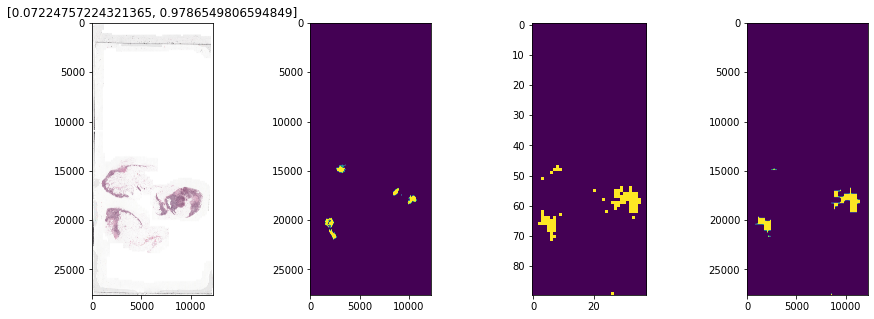

In [ ]:
mdl_9_3_wo_ft_wo_da = create_model_keras_inputs_three(fine_tune = False)
history, y_pred_binary = run_model(mdl_9_3_wo_ft_wo_da,path_mdl_9_3_wo_ft_wo_da, X_test)
run_prediction(history, y_pred_binary, patches_num_test)

#del mdl_9_3_wo_ft_wo_da, history, y_pred_binary

False Positive rate: 0.01
False Negative rate: 0.38
True Positive rate: 0.62
True Negative rate: 0.99
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3359
           1       0.43      0.62      0.51        61

    accuracy                           0.98      3420
   macro avg       0.71      0.80      0.75      3420
weighted avg       0.98      0.98      0.98      3420

AUC score: 0.8


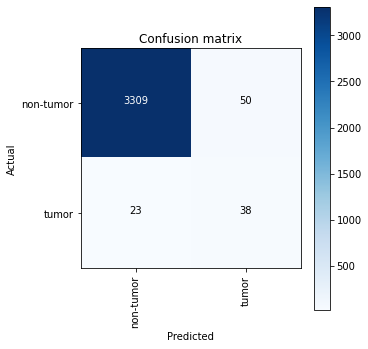

In [ ]:
print_stats(label_test, y_pred_binary)

### Version b <br>
#### A model train with 9 train, 3 val [per image]
#### model **with** fine tuning and **without** data augmentation

87916544/87910968 [==============================] - 0s 0us/step
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
107/107 [==============================] - 24s 125ms/step - loss: 0.0415 - accuracy: 0.9926
12224 27584


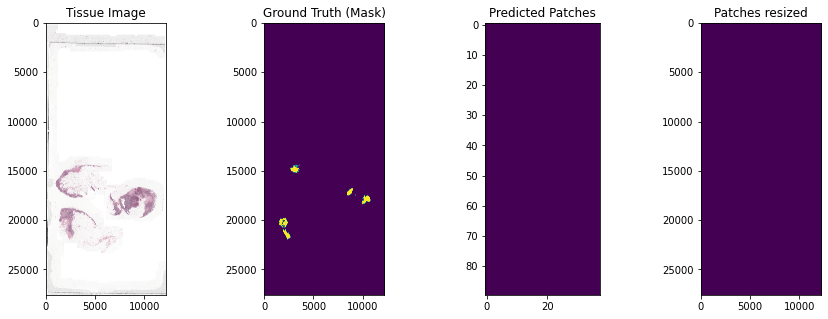

In [17]:
mdl_9_3_w_ft_wo_da = create_model_keras_inputs_three(fine_tune = True)
history, y_pred_binary = run_model(mdl_9_3_w_ft_wo_da,path_mdl_9_3_w_ft_wo_da, X_test)
run_prediction(history, y_pred_binary, patches_num_test)

#del mdl_9_3_w_ft_wo_da, history, y_pred_binary

False Positive rate: 0.0
False Negative rate: 1.0
True Positive rate: 0.0
True Negative rate: 1.0
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3359
           1       0.00      0.00      0.00        61

    accuracy                           0.98      3420
   macro avg       0.49      0.50      0.50      3420
weighted avg       0.96      0.98      0.97      3420

AUC score: 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


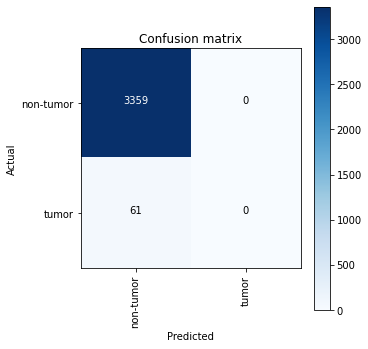

In [ ]:
print_stats(label_test, y_pred_binary)

### Version c: <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **with** data augmentation

466/466 [==============================] - 71s 143ms/step - loss: 0.0225 - accuracy: 0.9977
12224 27584


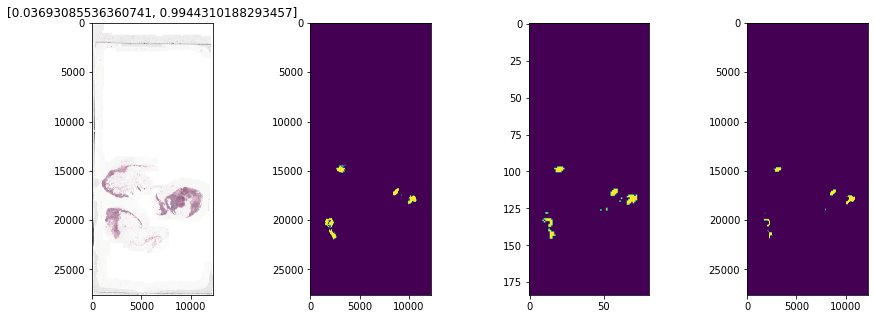

In [ ]:
mdl_9_3_wo_ft_w_da = create_model_keras_inputs_two(fine_tune = False)
history, y_pred_binary = run_model(mdl_9_3_wo_ft_w_da,path_mdl_9_3_wo_ft_w_da, X_test)
run_prediction(history, y_pred_binary, patches_num_test)

#del mdl_9_3_wo_ft_w_da, history, y_pred_binary

False Positive rate: 0.0
False Negative rate: 0.4
True Positive rate: 0.6
True Negative rate: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14728
           1       0.89      0.60      0.72       176

    accuracy                           0.99     14904
   macro avg       0.94      0.80      0.86     14904
weighted avg       0.99      0.99      0.99     14904

AUC score: 0.8


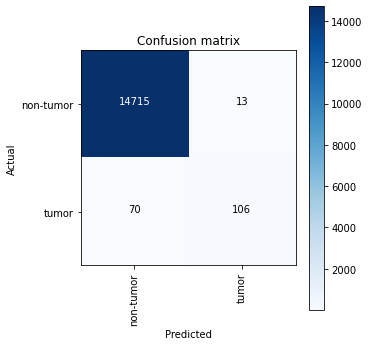

In [ ]:
print_stats(label_test, y_pred_binary)

### Version d: <br>
#### A model train with 9 train, 3 val [per image]
#### model **with** fine tuning and **with** data augmentation

In [ ]:
mdl_9_3_w_ft_w_da = create_model_keras_inputs_two(fine_tune = True)
history, y_pred_binary = run_model(mdl_9_3_w_ft_w_da,path_mdl_9_3_w_ft_w_da, X_test)
run_prediction(history, y_pred_binary, patches_num_test)

#del mdl_9_3_w_ft_w_da, history, y_pred_binary

NameError: ignored

False Positive rate: 0.0
False Negative rate: 0.4
True Positive rate: 0.6
True Negative rate: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14728
           1       0.89      0.60      0.72       176

    accuracy                           0.99     14904
   macro avg       0.94      0.80      0.86     14904
weighted avg       0.99      0.99      0.99     14904

AUC score: 0.8


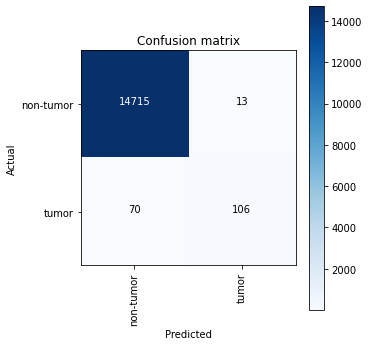

In [ ]:
print_stats(label_test, y_pred_binary)

### Version 2.1: <br>
#### A model train with 9 train, 3 val [per image]
#### model **with** fine tuning and **without** data augmentation
#### Dropout applied after concatenating Inception V3 model

## 나중에 BatchNormalization도 넣어야함

Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
107/107 [==============================] - 30s 212ms/step - loss: 0.0375 - accuracy: 0.9923
12224 27584


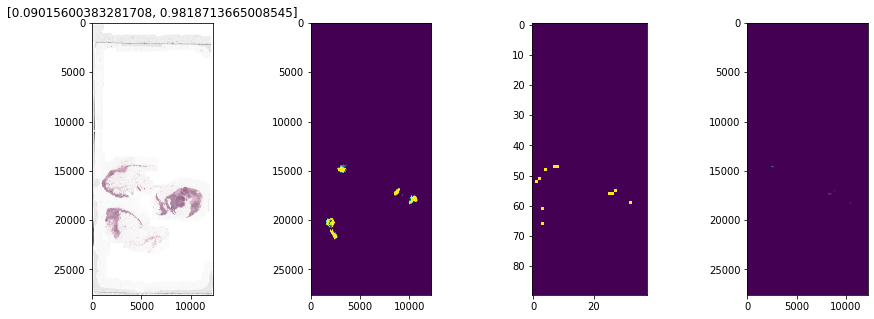

In [ ]:
mdl_9_3_w_ft_wo_da_Dropout = create_model_keras_inputs_two_updated(fine_tune = True)
history, y_pred_binary = run_model(mdl_9_3_w_ft_wo_da_Dropout,path_mdl_9_3_w_ft_wo_da_Dropout, X_test)
run_prediction(history, y_pred_binary, patches_num_test)

#del mdl_9_3_w_ft_wo_da_Dropout, history, y_pred_binary

False Positive rate: 0.0
False Negative rate: 0.92
True Positive rate: 0.08
True Negative rate: 1.0
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3359
           1       0.45      0.08      0.14        61

    accuracy                           0.98      3420
   macro avg       0.72      0.54      0.56      3420
weighted avg       0.97      0.98      0.98      3420

AUC score: 0.54


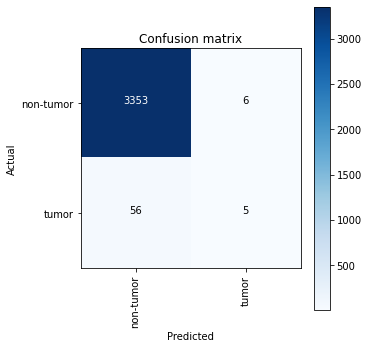

In [ ]:
print_stats(label_test, y_pred_binary)